# Collecting Data from Visible and Thermal Cameras from Plants

In [1]:
import sys
sys.path.append('..')

In [2]:
import time
import datetime
import threading
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from IPython import display

from skimage.exposure import rescale_intensity, equalize_adapthist

from cameras.wrapper_boson import BosonWithTelemetry
from cameras.wrapper_pyspin import Blackfly
from lights.light_intensity_controller import LightIntensityController
from thorlabs_elliptec import ELLx

# Initialize Hardware

In [3]:
USE_STAGE = True
STAGE_POS_BP680 = 0
STAGE_POS_LP700 = 31
STAGE_POS_SP700 = 62
STAGE_POS_CLEAR = 93

In [4]:
vis_cam_obj = Blackfly()
vis_cam_obj.set_fps(50)
vis_cam_obj.set_gain(0)
vis_cam_obj.set_exposure(1000)

Current FPS: 50.000000...
Gain set to 0.000000 dB...
Exposure set to 1008.093357 us...


In [5]:
thr_cam_obj = BosonWithTelemetry()

In [6]:
if USE_STAGE:
    curr_stage_pos = STAGE_POS_LP700
    stage = ELLx()
    stage.move_absolute_raw(curr_stage_pos)

In [7]:
light_obj = LightIntensityController()
light_obj.set_voltage(0.0)

## Preview Visible Camera

In [8]:
# high_voltage = 0.6
# curr_stage_pos = STAGE_POS_LP700
# curr_exposure = 10000
# stage.move_absolute_raw(curr_stage_pos)
# vis_cam_obj.set_exposure(curr_exposure)

In [9]:
# ## Collect an image with light at 0
# light_obj.set_voltage(0.0)
# for _ in tqdm(range(10)):
#     vis_cam_obj.get_next_image()
# vis_cam_img1 = vis_cam_obj.get_next_image().astype(np.float32)

# ## Change the light intensity to 1.0
# light_obj.set_voltage(high_voltage)
# for _ in tqdm(range(10)):
#     vis_cam_obj.get_next_image()
# vis_cam_img2 = vis_cam_obj.get_next_image().astype(np.float32)

# ## Change the light intensity to 0.0
# light_obj.set_voltage(0.0)

In [10]:
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# ax[0].imshow(vis_cam_img1, cmap='gray')
# ax[0].set_title('Light Intensity = 0.0')

# ax[1].imshow(vis_cam_img2, cmap='gray')
# ax[1].set_title('Light Intensity = 1.0')

# ax[2].imshow(vis_cam_img2 - vis_cam_img1, cmap='gray')
# ax[2].set_title('Difference')

# plt.tight_layout()
# plt.show()
# save_image_filename = f'light_intensity_test_v{high_voltage}_e{curr_exposure}_f{curr_stage_pos}.png'
# fig.savefig(save_image_filename)


## Preview Thermal Camera

In [11]:
def preview_thermal_frame(frame_raw: np.ndarray, in_range='image', equalize=False, apply_colormap=True) -> np.ndarray:
    frame = rescale_intensity(frame_raw.astype(float), in_range=in_range, out_range=(0, 1.0))
    if equalize:
        frame = np.uint8(equalize_adapthist(frame) * 255)
    else:
        frame = np.uint8(frame * 255)
    if apply_colormap:
        frame = cv2.applyColorMap(frame, cv2.COLORMAP_TURBO)[..., ::-1]
    return frame

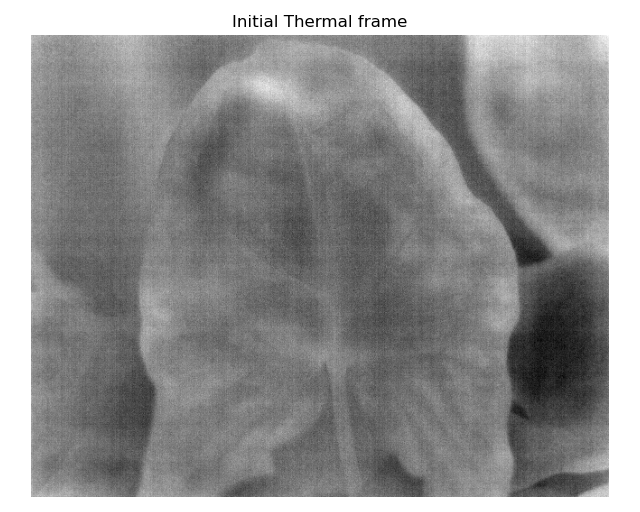

In [14]:
thr_cam_obj.camera.do_ffc()

num_init = 100
init_frame = np.zeros((512, 640), dtype=np.float32)
for _ in range(num_init):
    frame_init, frame_timestamp = thr_cam_obj.get_next_image()
    frame_init = frame_init[:, ::-1]
    init_frame += frame_init
init_frame /= num_init

fig, ax = plt.subplots(1, 1, figsize=(6.4, 5.12))
ax.imshow(init_frame, cmap='gray')
# ax.imshow(preview_thermal_frame(init_frame, apply_colormap=False), cmap='gray')
ax.set_title('Initial Thermal frame')
ax.axis('off')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

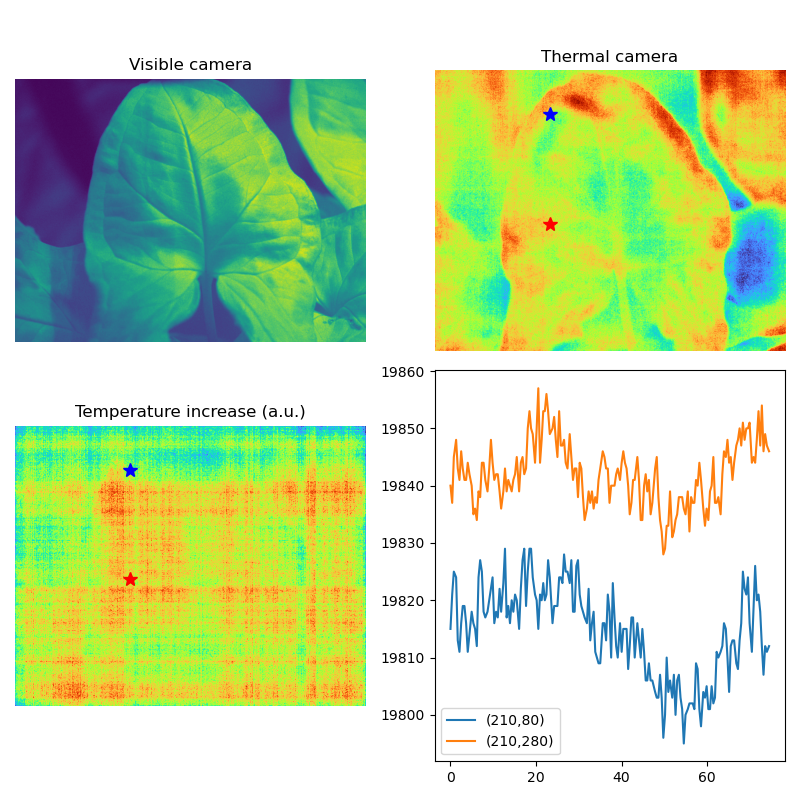

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

curr_stage_pos = STAGE_POS_LP700
stage.move_absolute_raw(curr_stage_pos)

pixel_val1 = []
pixel_val2 = []
tstamp = []
py1, px1 = 80, 210
py2, px2 = 280, 210

moving_average_frame = None
diff_threshold = 10
num_stabilized_frames = 10
frame_diffs = []

start_time = time.time()
while True:
    tic = time.time()

    vis_img, vis_tstamp = vis_cam_obj.get_next_image(), time.time()
    thr_img, thr_tstamp = thr_cam_obj.get_next_image()

    thr_img = thr_img[:, ::-1].astype(np.float32)
    thr_img_viz = thr_img #- init_frame
    diff_img_viz = thr_img - init_frame

    pixel_val1.append(thr_img_viz[py1, px1])
    pixel_val2.append(thr_img_viz[py2, px2])
    tstamp.append(thr_tstamp - start_time)

    min_val, max_val = np.percentile(thr_img_viz, [0.01, 99.99])
    thr_img_viz = rescale_intensity(thr_img_viz, in_range=(min_val, max_val), out_range=(0, 1.0))*255
    thr_img_viz = thr_img_viz.astype(np.uint8)

    min_val, max_val = np.percentile(diff_img_viz, [0.01, 99.99])
    diff_img_viz = rescale_intensity(diff_img_viz, in_range=(min_val, max_val), out_range=(0, 1.0))*255
    diff_img_viz = diff_img_viz.astype(np.uint8)

    if moving_average_frame is not None:
        frame_diff = np.median(np.abs(thr_img - moving_average_frame))
        frame_diffs.append(frame_diff)

        if len(frame_diffs) > num_stabilized_frames:
            frame_diffs.pop(0)

        if len(frame_diffs) == num_stabilized_frames and all([diff < diff_threshold for diff in frame_diffs]):
            print("Stabilized. Mean diff: {:.2f}".format(np.mean(frame_diffs)))
        else:
            print("Not stabilized. Mean diff: {:.2f}".format(np.mean(frame_diffs)))
        moving_average_frame = 0.9 * moving_average_frame + 0.1 * thr_img
    else:
        moving_average_frame = thr_img

    axes[0, 0].clear()
    axes[0, 0].imshow(vis_img)
    axes[0, 0].axis('off')
    axes[0, 0].set_title('Visible camera')
    # axes[0].scatter(px1, py1, c='b', s=10)
    # axes[0].scatter(px2, py2, c='r', s=10)

    axes[0, 1].clear()
    axes[0, 1].imshow(thr_img_viz, cmap='turbo')
    axes[0, 1].plot(px1, py1, 'b*', markersize=10)
    axes[0, 1].plot(px2, py2, 'r*', markersize=10)
    axes[0, 1].set_title('Thermal camera')
    axes[0, 1].axis('off')
    axes[1, 0].clear()
    axes[1, 0].imshow(diff_img_viz, cmap='turbo')
    axes[1, 0].set_title('Temperature increase (a.u.)')
    axes[1, 0].plot(px1, py1, 'b*', markersize=10)
    axes[1, 0].plot(px2, py2, 'r*', markersize=10)
    axes[1, 0].axis('off')
    axes[1, 1].clear()
    axes[1, 1].plot(tstamp, pixel_val1, label="({},{})".format(px1, py1))
    axes[1, 1].plot(tstamp, pixel_val2, label="({},{})".format(px2, py2))
    axes[1, 1].legend()
    plt.tight_layout()
    display.clear_output(wait=True)
    display.display(plt.gcf())


## Data Collection Routine

In [16]:
pulsetrain_settings = {
        'num_pulses' : 7,
        'light_control_voltages': [0.6, 1.2, 1.8, 2.5, 5.0, 7.5, 10],                 # in volts
        'light_intensity_perc'  : [2.47, 5.50, 9.94, 15.97, 37.35, 69.37, 100],       # roughly converted from voltage to intensity percentage
        'light_pulse_duration'  : [20, 20, 20, 20, 20, 20, 20],               # in s
        'relaxation_duration'   : [180, 180, 180, 180, 180, 180, 180],                # in s
        'fps_during_pulse' : 50,
        'fps_between_pulses' : 3,
        'vis_cam_exposure_sp700' : [300, 200, 200, 100, 40, 40, 40],
        'vis_cam_exposure_lp700' : [10000, 10000, 10000, 5000, 2000, 1000, 1000]
}

# pulsetrain_settings['pulse_energy'] = 200
# pulsetrain_settings['light_pulse_duration'] = [np.round(pulsetrain_settings['pulse_energy'] / i, 0) for i in pulsetrain_settings['light_intensity_perc']]     # in s
# pulsetrain_settings['relaxation_duration'] = [120 for _ in pulsetrain_settings['light_intensity_perc']]                                # in s

In [17]:
# pulsetrain_settings = {
#         'num_pulses' : 3,
#         'light_control_voltages': [0.6, 1.8, 2.5],                 # in volts
#         'light_intensity_perc'  : [2.47, 9.94, 15.97],       # roughly converted from voltage to intensity percentage
#         'light_pulse_duration' : [30, 20, 15],
#         'relaxation_duration' : [60, 60, 60],
#         'fps_during_pulse' : 50,
#         'fps_between_pulses' : 3,
#         'vis_cam_exposure_sp700' : [300, 200, 100],
#         'vis_cam_exposure_lp700' : [10000, 10000, 5000]
# }

# # pulsetrain_settings['pulse_energy'] = 200
# # pulsetrain_settings['light_pulse_duration'] = [np.round(pulsetrain_settings['pulse_energy'] / i, 0) for i in pulsetrain_settings['light_intensity_perc']]     # in s
# # pulsetrain_settings['relaxation_duration'] = [120 for _ in pulsetrain_settings['light_intensity_perc']]                                # in s

In [18]:
def collect_sp700_image(exposure):
    global ls_vis_frames
    global ls_vis_tstamps
    global ls_vis_exposures
    global ls_vis_filter_pos

    # Set filter position to SP700
    curr_stage_pos = STAGE_POS_SP700
    stage.move_absolute_raw(curr_stage_pos, True)

    # Set the exposure for the visible camera
    curr_exp = vis_cam_obj.get_exposure()
    vis_cam_obj.set_exposure(exposure)

    vis_img, vis_tstamp = vis_cam_obj.get_next_image(), time.time()

    ls_vis_frames.append(vis_img)
    ls_vis_tstamps.append(vis_tstamp)
    ls_vis_exposures.append(vis_cam_obj.get_exposure())
    ls_vis_filter_pos.append(curr_stage_pos)

    # Set filter position to LP700
    curr_stage_pos = STAGE_POS_LP700
    stage.move_absolute_raw(curr_stage_pos, True)

    # Reset the exposure for the visible camera
    vis_cam_obj.set_exposure(curr_exp)

In [19]:
running = True
pause_recording = False

save_fps = pulsetrain_settings['fps_between_pulses']
light_obj.set_voltage(0.0)
curr_stage_pos = STAGE_POS_LP700
stage.move_absolute_raw(curr_stage_pos, True)
vis_cam_obj.set_exposure(pulsetrain_settings['vis_cam_exposure_lp700'][0])

## Set up capture thread for visible camera
ls_vis_frames = []
ls_vis_tstamps = []
ls_vis_exposures = []
ls_vis_filter_pos = []

def visible_capture_thread():
    global ls_vis_frames
    global ls_vis_tstamps
    global ls_vis_exposures
    global running
    global pause_recording
    global save_fps
    global curr_stage_pos
    last_frame_time = time.time()

    while running:
        if pause_recording:
            continue
        vis_img, vis_tstamp = vis_cam_obj.get_next_image(), time.time()
        if vis_tstamp - last_frame_time > 1 / save_fps:
            ls_vis_frames.append(vis_img)
            ls_vis_tstamps.append(vis_tstamp)
            ls_vis_exposures.append(vis_cam_obj.get_exposure())
            ls_vis_filter_pos.append(curr_stage_pos)
            last_frame_time = vis_tstamp

vis_cap_thread = threading.Thread(target=visible_capture_thread)

# Set up capture thread for thermal camera
ls_thr_frames = []
ls_thr_tstamps = []

def thermal_capture_thread():
    global ls_thr_frames
    global ls_thr_tstamps
    global running
    global pause_recording
    global save_fps
    _, last_frame_time = thr_cam_obj.get_next_image()

    while running:
        # if pause_recording:
        #     continue
        thr_img, thr_tstamp = thr_cam_obj.get_next_image()
        if thr_tstamp - last_frame_time > 1 / save_fps:
            ls_thr_frames.append(thr_img)
            ls_thr_tstamps.append(thr_tstamp)
            last_frame_time = thr_tstamp

thr_cap_thread = threading.Thread(target=thermal_capture_thread)

# Set FFC to manual for the thermal camera
thr_cam_obj.camera.set_ffc_manual()
# Do FFC for the thermal camera
thr_cam_obj.camera.do_ffc()
time.sleep(1)

# Start the threads
vis_cap_thread.start()
thr_cap_thread.start()

# Light pulse routine
num_pulses = pulsetrain_settings['num_pulses']
# Initial relaxation period
time.sleep(5)
for i in range(num_pulses):
    print(f"Pulse {i+1} of {num_pulses}")
# for i in range(num_pulses-1, -1, -1):
#     print(f"Pulse {i+1} of {num_pulses}")

    pause_recording = True
    time.sleep(0.5)

    collect_sp700_image(pulsetrain_settings['vis_cam_exposure_sp700'][0])

    # Set the exposure for the visible camera
    vis_cam_obj.set_exposure(pulsetrain_settings['vis_cam_exposure_lp700'][i])

    # Change the save fps
    save_fps = pulsetrain_settings['fps_during_pulse']

    pause_recording = False
    time.sleep(0.5)

    # Set the light intensity
    print(f"Setting light intensity to {pulsetrain_settings['light_intensity_perc'][i]}%")
    light_obj.set_voltage(pulsetrain_settings['light_control_voltages'][i])
    # Record the light pulse
    time.sleep(pulsetrain_settings['light_pulse_duration'][i])

    pause_recording = True
    time.sleep(0.5)

    collect_sp700_image(pulsetrain_settings['vis_cam_exposure_sp700'][i])

    # Set the exposure for the visible camera
    vis_cam_obj.set_exposure(pulsetrain_settings['vis_cam_exposure_lp700'][0])
    
    pause_recording = False
    time.sleep(0.5)

    # Turn off the light
    print("Turning off the light")
    light_obj.set_voltage(0.0)

    # Change the save fps
    save_fps = pulsetrain_settings['fps_between_pulses']

    # Record the relaxation period
    time.sleep(pulsetrain_settings['relaxation_duration'][i])

# Set FFC to Auto
thr_cam_obj.camera.set_ffc_auto()
thr_cam_obj.camera.do_ffc()

print("Stopping the threads")
running = False
vis_cap_thread.join()
thr_cap_thread.join()

print("Saving the data")
ls_vis_frames = np.array(ls_vis_frames)
ls_vis_tstamps = np.array(ls_vis_tstamps)
ls_vis_exposures = np.array(ls_vis_exposures)
ls_vis_filter_pos = np.array(ls_vis_filter_pos)

ls_thr_frames = np.array(ls_thr_frames)
ls_thr_tstamps = np.array(ls_thr_tstamps)

output_filename = '../data/pulse_train_{}.npz'.format(time.strftime("%Y%m%d-%H%M%S"))
np.savez(output_filename, ls_vis_frames=ls_vis_frames,
                          ls_vis_tstamps=ls_vis_tstamps,
                          ls_vis_exposures=ls_vis_exposures,
                          ls_vis_filter_pos=ls_vis_filter_pos,
                          ls_thr_frames=ls_thr_frames,
                          ls_thr_tstamps=ls_thr_tstamps, **pulsetrain_settings)
                          


Exposure set to 9988.486767 us...
Pulse 1 of 7
Exposure set to 288.367271 us...
Exposure set to 9988.486767 us...
Exposure set to 9988.486767 us...
Setting light intensity to 2.47%
Exposure set to 288.367271 us...
Exposure set to 9988.486767 us...
Exposure set to 9988.486767 us...
Turning off the light
Pulse 2 of 7
Exposure set to 288.367271 us...
Exposure set to 9988.486767 us...
Exposure set to 9988.486767 us...
Setting light intensity to 5.5%
Exposure set to 194.489956 us...
Exposure set to 9988.486767 us...
Exposure set to 9988.486767 us...
Turning off the light
Pulse 3 of 7
Exposure set to 288.367271 us...
Exposure set to 9988.486767 us...
Exposure set to 9988.486767 us...
Setting light intensity to 9.94%
Exposure set to 194.489956 us...
Exposure set to 9988.486767 us...
Exposure set to 9988.486767 us...
Turning off the light
Pulse 4 of 7
Exposure set to 288.367271 us...
Exposure set to 9988.486767 us...
Exposure set to 5013.287067 us...
Setting light intensity to 15.97%
Exposure 

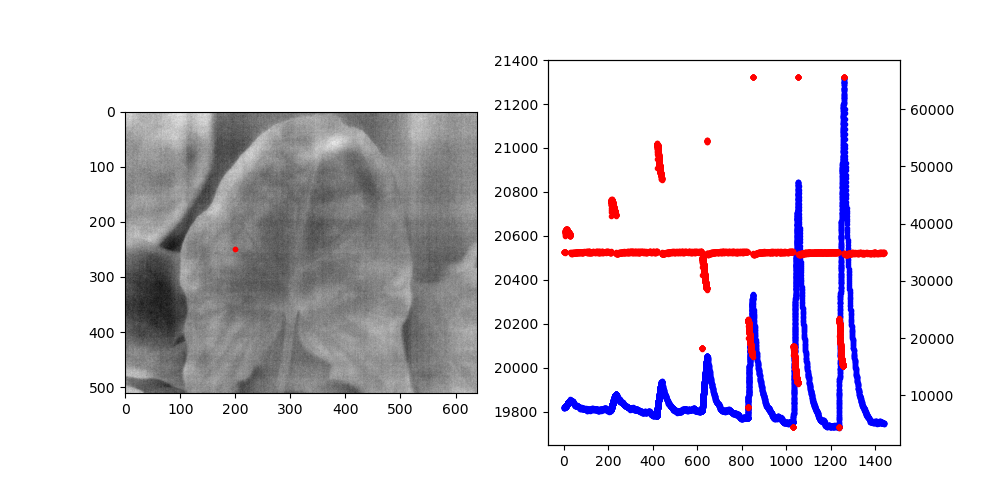

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(ls_thr_frames[1000, :, :], cmap='gray')
ax[0].scatter(200, 250, c='r', s=10)
# ax[0].imshow(ls_vis_frames[60, :, :], cmap='gray')
# ax[0].scatter(530, 260, c='b', s=10)
ax[1].plot(ls_thr_tstamps - ls_vis_tstamps[0], ls_thr_frames[:, 250:255, 200:205].mean(axis=(1, 2)), 'b.')
ax2 = ax[1].twinx()
vis_pixel_val = []
vis_pixel_tstamp = []
for i in range(ls_vis_frames.shape[0]):
    if ls_vis_filter_pos[i] == STAGE_POS_LP700:
        vis_pixel_val.append(ls_vis_frames[i, 260:265, 530:535].mean())
        vis_pixel_tstamp.append(ls_vis_tstamps[i] - ls_vis_tstamps[0])
ax2.plot(vis_pixel_tstamp, vis_pixel_val, 'r.')
plt.show()

In [ ]:
from ipywidgets import interact, IntSlider

plt.figure(figsize=(10, 5))

def show_frame(frame_number):
    plt.imshow(ls_vis_frames[frame_number, :, :], cmap='gray')
    plt.title(f'Frame {frame_number}, time: {ls_vis_tstamps[frame_number] - ls_vis_tstamps[0]:.2f}, filter pos: {ls_vis_filter_pos[frame_number]}, min: {ls_vis_frames[frame_number].min()}, max: {ls_vis_frames[frame_number].max()}')
    plt.show()

interact(show_frame, frame_number=IntSlider(min=0, max=len(ls_vis_frames)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='frame_number', max=8280), Output()), _dom_classes=('widg…

<function __main__.show_frame(frame_number)>

In [36]:
light_obj.set_voltage(0)